In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
from IPython.display import display, HTML

In [2]:
matches = pd.read_csv('Desktop/Python/Kaggle/WorldCup2018/results.csv')

In [3]:
matches.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [4]:
# set the type of date to datetime
matches = matches.astype({'date': 'datetime64[ns]'})

Text(0.5,1,'Top 10 Type of Match Tournaments')

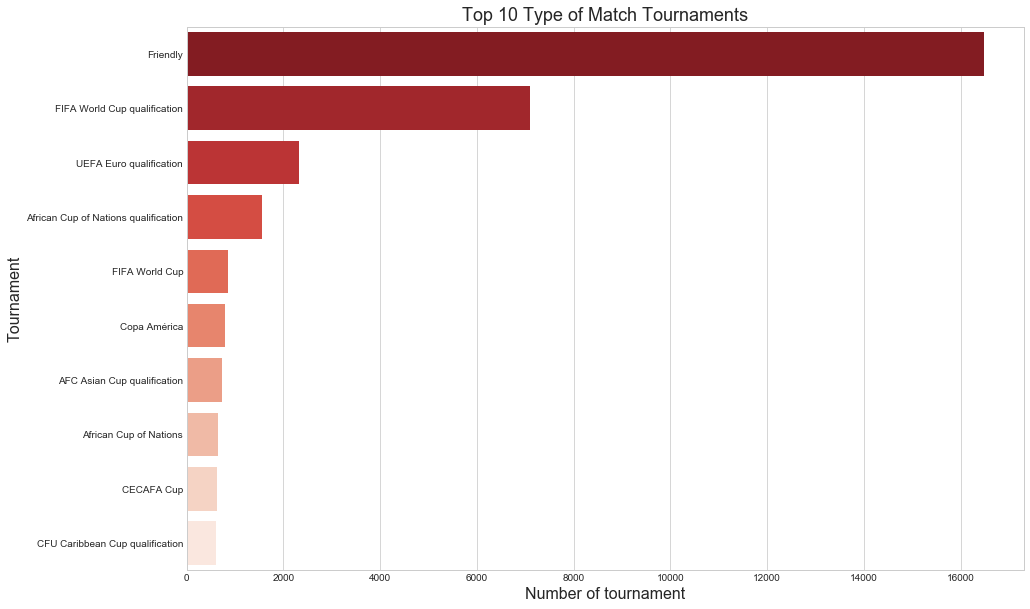

In [7]:
tournament = matches['tournament'].value_counts()
tournament = tournament[:10]

plt.figure(figsize=(15,10))
# sns.set_style('whitegrid')
ax = sns.barplot(y=tournament.index, x=tournament.values, palette='Reds_r', orient='h')
ax.set_ylabel('Tournament', size=16)
ax.set_xlabel('Number of tournament', size=16)
ax.set_title('Top 10 Type of Match Tournaments', fontsize=18)

In [27]:
# create a dataframe with some statistics by team like the sum, count and mean of score for each team
home = matches[['home_team', 'home_score']].rename(columns={'home_team':'team', 'home_score':'score'})
away = matches[['away_team', 'away_score']].rename(columns={'away_team': 'team', 'away_score':'score'})

# merge it to one
team_score = home.append(away).reset_index(drop=True)
# make an aggregation of the score column group by the team
country_info = team_score.groupby('team')['score'].agg(['sum', 'count', 'mean']).reset_index()
country_info = country_info.rename(columns={'sum':'nb_goals', 'count':'nb_matches', 'mean':'goal_avg'})
country_info.head()

,team,nb_goals,nb_matches,goal_avg
0,Afghanistan,110,103,1.067961
1,Albania,287,316,0.908228
2,Algeria,675,484,1.394628
3,American Samoa,26,42,0.619048
4,Andorra,40,147,0.272109


Text(0.5,1,'Top 10 of Goal Average Per Match')

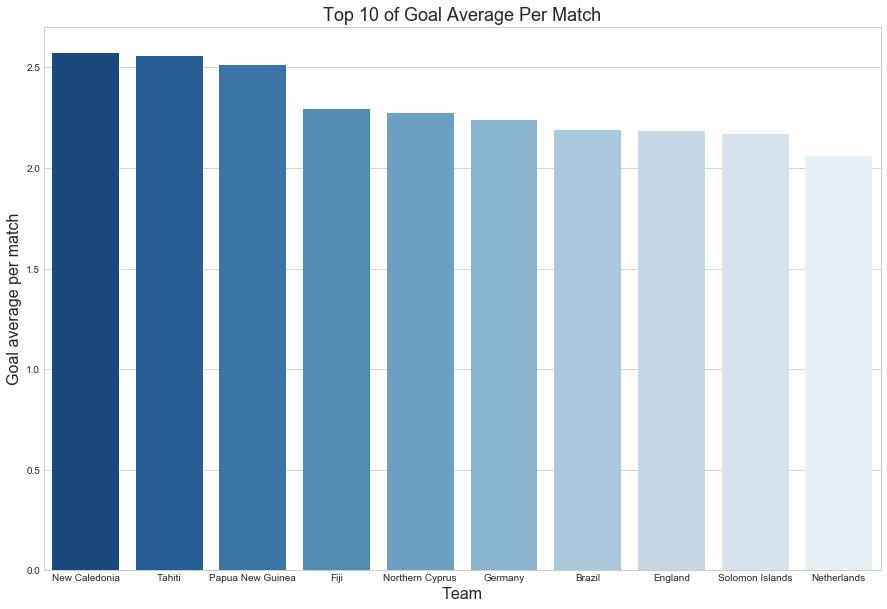

In [24]:
plt.figure(figsize=(15,10))
plt_data = country_info.sort_values(by='goal_avg', ascending=False)[:10]
ax = sns.barplot(x='team', y='goal_avg', data=plt_data, palette='Blues_r')
ax.set_xlabel('Team', size=16)
ax.set_ylabel('Goal average per match', size=16)
ax.set_title('Top 10 of Goal Average Per Match', fontsize=18)

Text(0.5,1,'Top 10 of number of matches')

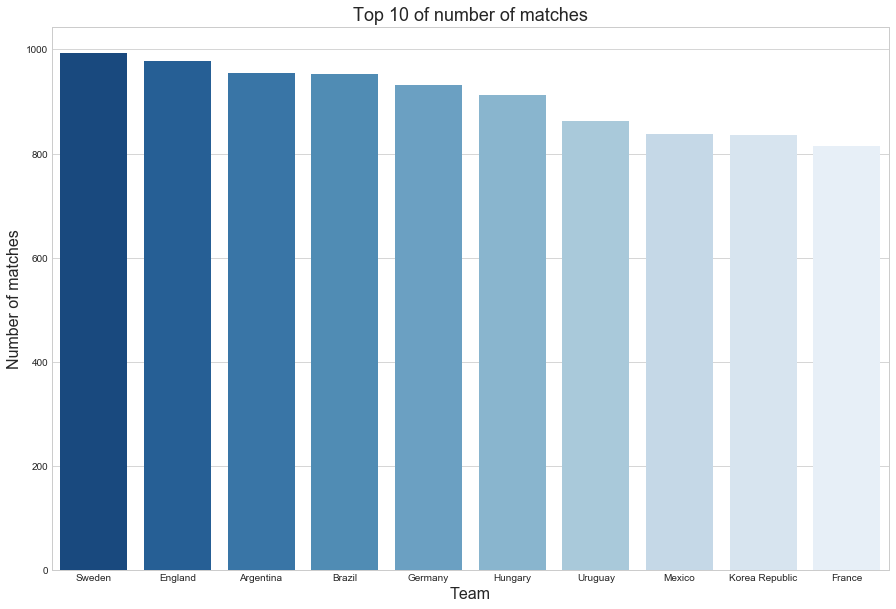

In [26]:
plt.figure(figsize=(15,10))
plt_data = country_info.sort_values(by='nb_matches', ascending=False)[:10]
ax = sns.barplot(x='team', y='nb_matches', data=plt_data, palette='Blues_r')
ax.set_xlabel('Team', size=16)
ax.set_ylabel('Number of matches', size=16)
ax.set_title("Top 10 of number of matches", fontsize=18)

Text(0.5,1,'Top 10 of number of goals')

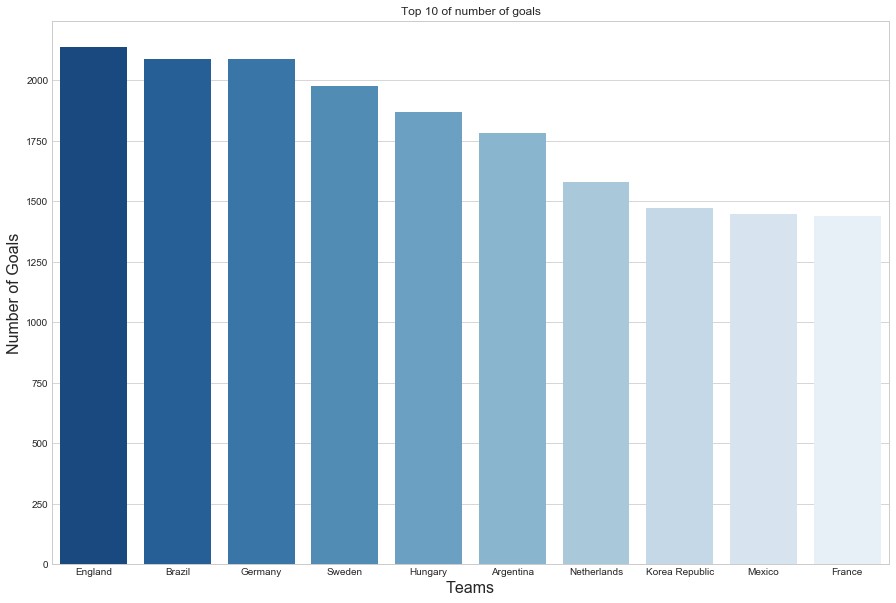

In [28]:
plt.figure(figsize=(15, 10))
plt_data = country_info.sort_values(by='nb_goals', ascending=False)[:10]
ax = sns.barplot(x='team', y='nb_goals', data=plt_data, palette='Blues_r')
ax.set_xlabel('Teams', size=16)
ax.set_ylabel('Number of Goals', size=16)
ax.set_title('Top 10 of number of goals')

In [29]:
means = matches[['home_score', 'away_score']].mean()
means

home_score    1.739724
away_score    1.179754
dtype: float64

In [30]:
"""
So now it's time to introduce the Poisson distribution : it's a discrete probability distribution (it provides the probabilities of occurrence of different possible outcomes in an event) that expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant rate and independently of the time since the last event
An important assumption is that each events are independent in time. Here, it means that goals don't become more or less likely by the number of goals that is already scored in a match. We can formulate this by the probability mass function :
"""

"\nSo now it's time to introduce the Poisson distribution : it's a discrete probability distribution (it provides the probabilities of occurrence of different possible outcomes in an event) that expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant rate and independently of the time since the last event\nAn important assumption is that each events are independent in time. Here, it means that goals don't become more or less likely by the number of goals that is already scored in a match. We can formulate this by the probability mass function :\n"

Text(0,0.5,'Proportion of Matches')

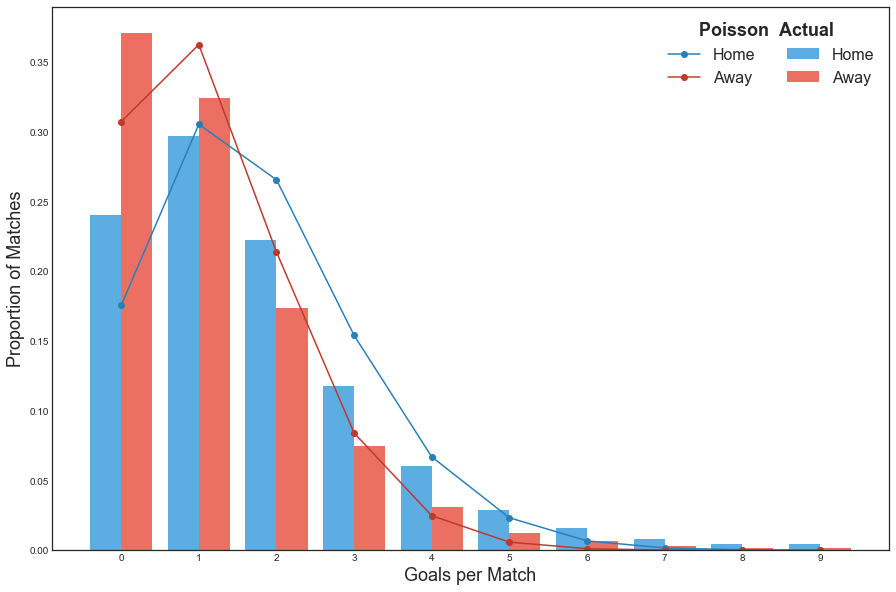

In [32]:
# Poisson distribution for the score (all team)
plt.figure(figsize=(15,10))
sns.set_style('white')

# construct Poisson for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(k,means[j]) for k in range(10)] for j in range(2)])

# plot histogram of actual goals
plt.hist(matches[['home_score', 'away_score']].values, range(11), alpha=0.8,
        label=['Home', 'Away'], normed=True, color=['#3498db', '#e74c3c'])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred[:,0],
                 linestyle='-', marker='o', label='Home', color='#2980b9')
pois2, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred[:,1],
                 linestyle='-', marker='o', label='Away', color='#c0392b') 
leg = plt.legend(loc='upper right', fontsize=16, ncol=2)
leg.set_title('Poisson  Actual  ', prop={'size': '18', 'weight': 'bold'})
plt.xticks([i-0.5 for i in range(1,11)],[i for i in range(11)])
plt.xlabel('Goals per Match', size=18)
plt.ylabel('Proportion of Matches', size=18)

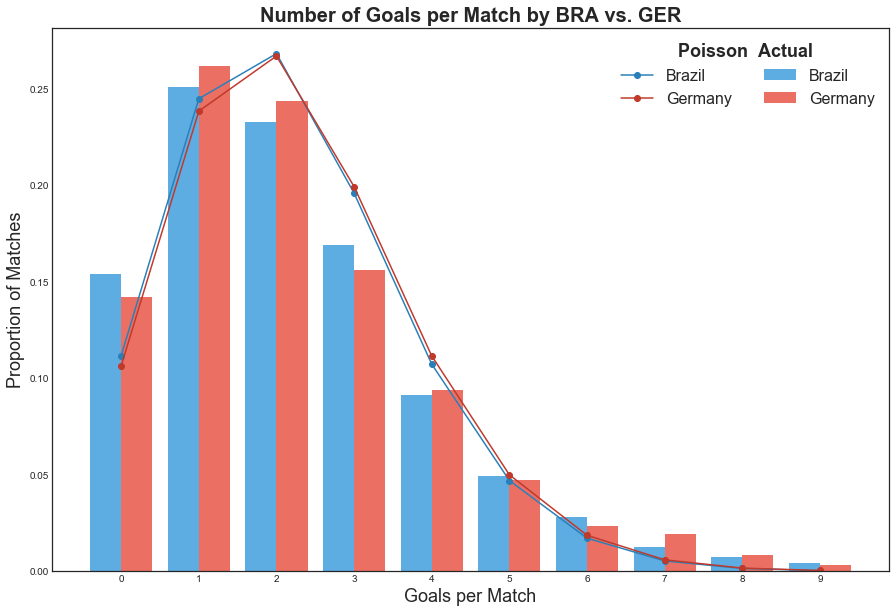

In [34]:
# Poisson distribution for the score (France and Germany)
plt.figure(figsize=(15,10))
sns.set_style('white')
team1, team2 = 'Brazil', 'Germany'
matches_t1 = team_score[team_score['team'] == team1]
matches_t2 = team_score[team_score['team'] == team2]

mean_t1 = matches_t1['score'].mean()
mean_t2 = matches_t2['score'].mean()

# construct Poisson for each mean goals value
poisson_pred_t1 = [poisson.pmf(k,mean_t1) for k in range(10)]
poisson_pred_t2 = [poisson.pmf(k,mean_t2) for k in range(10)]

# plot histogram of actual goals
plt.hist([matches_t1['score'].values, matches_t2['score'].values], range(11), alpha=0.8,
        label=[team1, team2], normed=True, color=["#3498db", "#e74c3c"])

# add lines for the Poisson distribution
pois1, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred_t1,
                 linestyle='-', marker='o', label=team1, color='#2980b9')
pois2, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred_t2,
                 linestyle='-', marker='o', label=team2, color='#c0392b')

leg = plt.legend(loc='upper right', fontsize=16, ncol=2)
leg.set_title('Poisson  Actual ', prop={'size':'18', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,11)], [i for i in range(11)])
plt.xlabel('Goals per Match', size=18)
plt.ylabel("Proportion of Matches", size=18)
plt.title('Number of Goals per Match by BRA vs. GER', size=20, fontweight='bold')
plt.show()

In [35]:
"""
Building the model
Now we can agree to say that each team follow the Poisson distribution due to the number of game. So first I will add a weight column that is based on the date of the game because it's obvious that a game that took place this year has more weight than the first game in 1872.

"""

"\nBuilding the model\nNow we can agree to say that each team follow the Poisson distribution due to the number of game. So first I will add a weight column that is based on the date of the game because it's obvious that a game that took place this year has more weight than the first game in 1872.\n\n"

In [37]:
def weight_from_tournament(tournament):
    if 'Cup' in tournament or 'Euro' in tournament:
        return 1
    else:
        return 100

# Create weight column based on the date
matches.loc[:, 'weight'] = matches['tournament'].apply(weight_from_tournament)
matches.loc[:, 'weight'] = 1/((2019-matches['date'].dt.year.astype('int64'))*matches['weight'])

# create model data
matches_model_data = pd.concat([matches[['home_team', 'away_team', 'home_score', 
                                         'weight']].rename(columns={'home_team':'team', 'away_team':'opponent', 'home_score':'goals'}),
                               matches[['away_team', 'home_team','away_score',
                                       'weight']].rename(columns={'away_team':'team', 'home_team':'opponent', 'away_score':'goals'})])

In [38]:
poisson_model = smf.glm(formula='goals ~ team + opponent', data=matches_model_data,
                       family=sm.families.Poisson(), freq_weights=matches_model_data['weight'].values).fit()

In [48]:
def get_proba_match(foot_model, team1, team2, max_goals=10):
    # Get the average goal for each team
    t1_goals_avg = foot_model.predict(pd.DataFrame(data={'team':team1, 'opponent':team2}, index=[1])).values[0]
    t2_goals_avg = foot_model.predict(pd.DataFrame(data={'team':team2, 'opponent':team1}, index=[1])).values[0]
    
    # Get probability of all possible score for each team
    team_pred = [[poisson.pmf(i,team_avg) for i in range(0,max_goals+1)] for team_avg in [t1_goals_avg, t2_goals_avg]]
    
    # Do the product of the 2 vectors to get the matrix of the match
    match = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    
    # Get the proba for each possible outcome
    t1_wins = np.sum(np.tril(match, -1))
    draw = np.sum(np.diag(match))
    t2_wins = np.sum(np.triu(match, 1))
    result_proba = [t1_wins, draw, t2_wins]
    
    # Adjust the proba to sum to one
    result_proba = np.array(result_proba)/np.array(result_proba).sum(axis=0,keepdims=1)
    team_pred[0] = np.array(team_pred[0])/np.array(team_pred[0]).sum(axis=0,keepdims=1)
    team_pred[1] = np.array(team_pred[1])/np.array(team_pred[1]).sum(axis=0,keepdims=1)
    return result_proba, [np.array(team_pred[0]), np.array(team_pred[1])]

In [49]:
def get_match_result(foot_model, team1, team2, elimination=False, max_draw=50, max_goals=10):
    # Get the proba
    proba, score_proba = get_proba_match(foot_model, team1, team2, max_goals)
    
    # Get the result, if it's an elimination game we have to be sure the result is not draw
    results = pd.Series([np.random.choice([team1, 'draw', team2], p=proba) for i in range(0, max_draw)]).value_counts()
    result = results.index[0] if not elimination or (elimination and results.index[0] != 'draw') else results.index[1]
    
    # if the result is not a draw game then we calculate the score of the winner from 1 to the max_goals
    # and the score of the looser from 0 to the score of the winner
    if (result != 'draw'):
        i_win, i_loose = (0,1) if result == team1 else (1,0)
        score_proba[i_win] = score_proba[i_win][1:]/score_proba[i_win][1:].sum(axis=0,keepdims=1)
        winner_score = pd.Series([np.random.choice(range(1,max_goals+1), 
                                                   p=score_proba[i_win]) for i in range(0,max_draw)]).value_counts().index[0]
        score_proba[i_loose] = score_proba[i_loose][:winner_score]/score_proba[i_loose][:winner_score].sum(axis=0,keepdims=1)
        looser_score = pd.Series([np.random.choice(range(0,winner_score),
                                                   p=score_proba[i_loose]) for i in range(0, max_draw)]).value_counts().index[0]
        score = [winner_score, looser_score]
        
        # if it is a draw then we calcualte a score and repear it twice
    else:
        score = np.repeat(pd.Series([np.random.choice(range(0, max_goals+1), 
                                                      p=score_proba[0]) for i in range(0,max_draw)]).value_counts().index[0],2)
    looser = team2 if result == team1 else team1 if result != 'draw' else 'draw'
    return result, looser, score

In [79]:
print(get_match_result(poisson_model, 'Brazil', 'Germany'))
print(get_match_result(poisson_model, 'Argentina', 'Germany'))
print(get_match_result(poisson_model, 'Brazil', 'Vatican', max_goals=20))

('Germany', 'Brazil', [2, 1])
('Germany', 'Argentina', [1, 0])
('Brazil', 'Vatican', [20, 0])


In [78]:
groupA = ['Russia', 'Saudi Arabia', 'Egypt', 'Uruguay']
groupB = ['Portugal', 'Spain', 'Morocco', 'Iran']
groupC = ['France', 'Australia', 'Peru', 'Denmark']
groupD = ['Argentina', 'Iceland', 'Croatia', 'Nigeria']
groupE = ['Brazil', 'Switzerland', 'Costa Rica', 'Serbia']
groupF = ['Germany', 'Mexico', 'Sweden', 'Korea Republic']
groupG = ['Belgium', 'Panama', 'Tunisia', 'England']
groupH = ['Poland', 'Senegal', 'Colombia', 'Japan']
groups = [groupA, groupB, groupC, groupD, groupE, groupF, groupG, groupH]

In [82]:
def get_group_result(foot_model, group):
    ranking = pd.DataFrame({'points':[0,0,0,0], 'diff':[0,0,0,0], 'goals':[0,0,0,0]}, index=group)
    for team1, team2 in itertools.combinations(group, 2):
        result,looser,score = get_match_result(foot_model,team1,team2)
        #print(result,'-',looser,':',score)
        if result == 'draw':
            ranking.loc[[team1,team2], 'points'] += 1
            ranking.loc[[team1, team2], 'goals'] += score[0]
        else:
            ranking.loc[result, 'points'] += 3
            ranking.loc[result, 'goals'] += score[0]
            ranking.loc[looser, 'goals'] += score[1]
            ranking.loc[result, 'diff'] += score[0] - score[1]
            ranking.loc[looser, 'diff'] -= score[0] - score[1]
    return ranking.sort_values(by=['points', 'diff', 'goals'], ascending=False)

def get_final_result(foot_model, groups_result):
    round_of_16 = []
    quarter_finals = []
    semi_finals = []
    
    # Simulate round of 16
    for i in range(0,8,2):
        round_of_16.append(get_match_result(foot_model,groups_result[i].index[0],
                                           groups_result[i+1].index[1], elimination=True))
        round_of_16.append(get_match_result(foot_model,groups_result[i].index[1],
                                           groups_result[i+1].index[0], elimination=True))
        
    # Simulate quarter finals
    quarter_finals.append(get_match_result(foot_model,round_of_16[0][0],
                                          round_of_16[2][0],elimination=True))
    quarter_finals.append(get_match_result(foot_model,round_of_16[1][0],
                                          round_of_16[3][0],elimination=True))
    quarter_finals.append(get_match_result(foot_model,round_of_16[4][0],
                                          round_of_16[6][0],elimination=True))
    quarter_finals.append(get_match_result(foot_model,round_of_16[5][0],
                                          round_of_16[7][0],elimination=True))
    
    # Simulate semi finals
    semi_finals.append(get_match_result(foot_model, quarter_finals[0][0],
                                        quarter_finals[2][0],elimination=True))
    semi_finals.append(get_match_result(foot_model, quarter_finals[1][0],
                                       quarter_finals[3][0],elimination=True))
    
    # Simulate 3rd place match
    little_final = get_match_result(foot_model, semi_finals[0][1],
                                    semi_finals[1][1],elimination=True)
    
    # Simulate final
    final = get_match_result(foot_model, semi_finals[0][0], 
                             semi_finals[1][0],elimination=True)
    return round_of_16, quarter_finals, semi_finals, little_final, final

In [83]:
groups_ranking = []
for group in groups:
    groups_ranking.append(get_group_result(poisson_model,group))
    
round_of_16, quarter_finals, semi_finals, little_final, final = get_final_result(poisson_model, groups_ranking)

In [84]:
for group_rank in groups_ranking:
    display(group_rank)

,diff,goals,points
Russia,3,4,7
Uruguay,2,4,7
Egypt,-2,1,3
Saudi Arabia,-3,1,0


,diff,goals,points
Spain,4,4,9
Portugal,0,2,4
Iran,-1,2,4
Morocco,-3,0,0


,diff,goals,points
France,4,4,9
Denmark,2,3,6
Peru,-2,1,3
Australia,-4,0,0


,diff,goals,points
Argentina,4,4,9
Croatia,1,2,6
Iceland,-2,1,3
Nigeria,-3,0,0


,diff,goals,points
Brazil,4,4,9
Switzerland,0,2,6
Serbia,-1,1,3
Costa Rica,-3,0,0


,diff,goals,points
Germany,5,6,9
Mexico,0,4,4
Sweden,-1,3,4
Korea Republic,-4,0,0


,diff,goals,points
England,3,3,9
Belgium,1,3,6
Tunisia,-2,2,1
Panama,-2,1,1


,diff,goals,points
Poland,1,2,6
Colombia,1,2,6
Japan,1,2,6
Senegal,-3,0,0


In [101]:

for semi_final in semi_finals:
    display(semi_final)

('Brazil', 'France', [2, 1])

('Spain', 'Germany', [2, 1])

In [102]:
for i in round_of_16:
    display(i)

('Portugal', 'Russia', [1, 0])

('Spain', 'Uruguay', [1, 0])

('France', 'Croatia', [1, 0])

('Argentina', 'Denmark', [1, 0])

('Brazil', 'Mexico', [1, 0])

('Germany', 'Switzerland', [1, 0])

('England', 'Colombia', [1, 0])

('Belgium', 'Poland', [2, 1])

In [103]:
for i in quarter_finals:
    display(i)

('France', 'Portugal', [1, 0])

('Spain', 'Argentina', [1, 0])

('Brazil', 'England', [1, 0])

('Germany', 'Belgium', [2, 0])

In [104]:
for i in semi_finals:
    display(i)

('Brazil', 'France', [2, 1])

('Spain', 'Germany', [2, 1])

In [105]:
little_final

('France', 'Germany', [1, 0])

In [106]:
final

('Brazil', 'Spain', [1, 0])

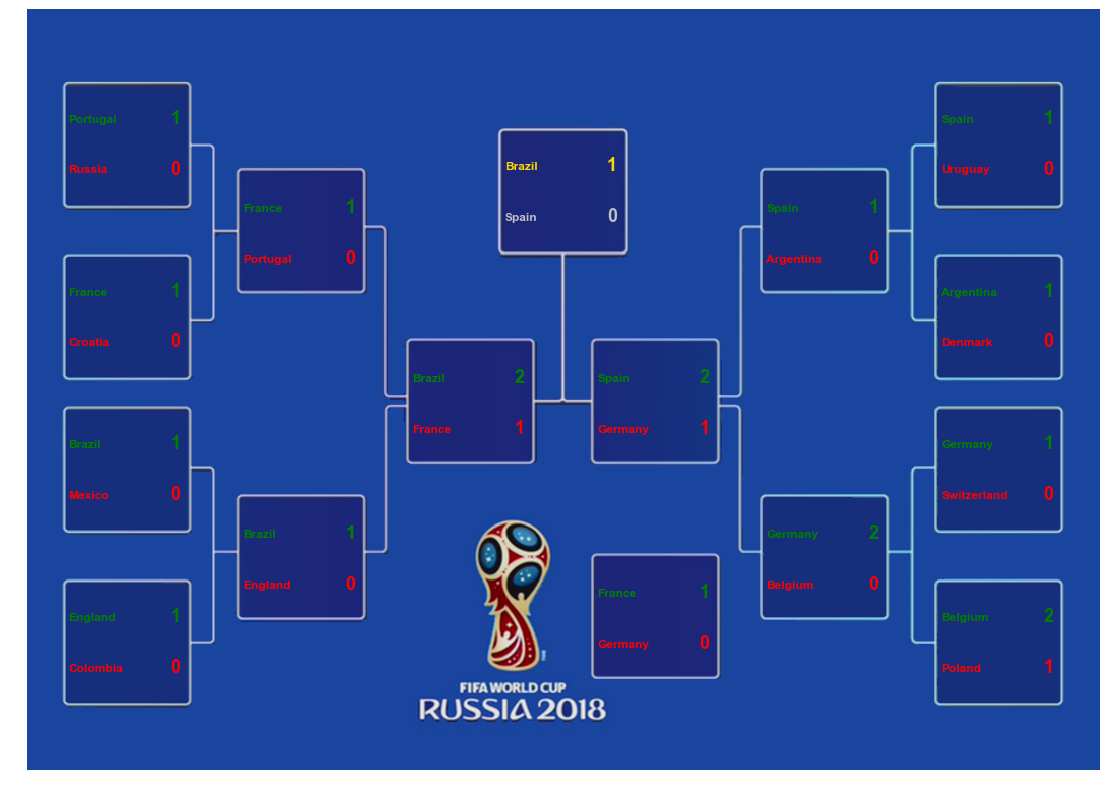

In [111]:
plt.figure(figsize = (25,14))
img = mpimg.imread('Desktop/Python/Kaggle/WorldCup2018/fifa-world-cup.png')
plt.imshow(img)
plt.axis('off')

def text_match(x,y,match,final=False):
    col_win, col_loose = ('green', 'red') if (not final) else ('gold', 'silver')
    plt.text(x,y,match[0], fontsize=12, color=col_win,weight='bold')
    plt.text(x+100,y+1,match[2][0],fontsize=18,color=col_win,weight='bold')
    plt.text(x,y+50,match[1], fontsize=12,color=col_loose, weight='bold')
    plt.text(x+100,y+51,match[2][1], fontsize=18, color=col_loose,weight='bold')
    
round_of_16_xy = [(40,110),(898,110),(40,280),(898,280),(40,430),(898,430),(40,600),(898,600)]
quarter_finals_xy = [(212,198),(726,198),(212,518),(726,518)]
semi_finals_xy = [(378,365),(560,365)]
x_little_final, y_little_final = 560, 576
x_final, y_final = 469, 157

for (x,y), match in zip(round_of_16_xy, round_of_16):
    text_match(x,y,match)
for (x,y), match in zip(quarter_finals_xy, quarter_finals):
    text_match(x,y,match)
for (x,y), match in zip(semi_finals_xy, semi_finals):
    text_match(x,y,match)
text_match(x_little_final, y_little_final, little_final)
text_match(x_final,y_final,final,final=True)
plt.show()